In [1]:
import numpy as np
import pandas as pd

import plotnine as pn

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import torch
from torch import nn
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit

In [2]:
# read in dataset
df = pd.read_csv('data/simulatedEmergenceCounts.csv')
df

,Unnamed: 0,Name,Date.time,Maximum.Temperature,Minimum.Temperature,Temperature,Wind.Chill,Heat.Index,Precipitation,Snow,...,Wind.Speed,Wind.Direction,Wind.Gust,Visibility,Cloud.Cover,Relative.Humidity,Conditions,day,yday,emergence
0,1,"Gainesville, FL, United States",1/1/20,65.9,39.0,51.0,35.6,NaN,0.00,0,...,6.8,263.29,NaN,9.9,9.1,64.82,Clear,2020-01-01,1,0
1,2,"Gainesville, FL, United States",1/2/20,77.0,46.1,60.5,44.9,NaN,0.00,0,...,10.3,116.88,19.2,9.9,8.0,72.16,Clear,2020-01-02,2,9856
2,3,"Gainesville, FL, United States",1/3/20,83.0,63.0,72.9,NaN,86.7,0.00,0,...,13.8,184.33,24.1,9.6,43.3,79.95,Partially cloudy,2020-01-03,3,73455
3,4,"Gainesville, FL, United States",1/4/20,73.1,56.0,68.0,NaN,NaN,0.68,0,...,16.0,237.46,28.9,9.3,51.4,81.07,"Rain, Partially cloudy",2020-01-04,4,6720
4,5,"Gainesville, FL, United States",1/5/20,61.1,39.0,48.5,35.6,NaN,0.00,0,...,12.7,278.42,21.9,9.9,0.0,57.43,Clear,2020-01-05,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,361,"Gainesville, FL, United States",12/26/20,63.0,25.1,42.9,39.1,NaN,0.00,0,...,10.2,54.50,NaN,9.9,0.0,69.97,Clear,2020-12-26,361,0
361,362,"Gainesville, FL, United States",12/27/20,71.9,37.2,53.0,35.0,NaN,0.00,0,...,6.9,44.88,NaN,9.9,5.0,74.20,Clear,2020-12-27,362,0
362,363,"Gainesville, FL, United States",12/28/20,71.9,39.9,54.5,NaN,NaN,0.00,0,...,12.6,75.96,NaN,9.9,7.1,75.82,Clear,2020-12-28,363,0
363,364,"Gainesville, FL, United States",12/29/20,75.8,46.3,60.3,NaN,NaN,0.00,0,...,12.6,57.38,18.3,8.5,37.8,83.65,Partially cloudy,2020-12-29,364,15021


Exam Correlations

In [4]:
# make correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Unnamed: 0,Maximum.Temperature,Minimum.Temperature,Temperature,Wind.Chill,Heat.Index,Precipitation,Snow,Snow.Depth,Wind.Speed,Wind.Direction,Wind.Gust,Visibility,Cloud.Cover,Relative.Humidity,yday,emergence
Unnamed: 0,1.000000,0.084485,0.179104,0.112188,-0.100614,0.417926,0.034074,nan,nan,-0.074459,-0.183962,0.037725,-0.038467,0.067858,0.374399,0.999989,0.203786
Maximum.Temperature,0.084485,1.000000,0.850990,0.950069,0.725036,0.885015,0.119916,nan,nan,0.023166,-0.126477,0.097921,-0.038054,-0.084288,0.335622,0.087490,0.476395
Minimum.Temperature,0.179104,0.850990,1.000000,0.961033,0.880882,0.799007,0.259330,nan,nan,0.077378,-0.115804,0.208794,-0.167837,0.225025,0.595148,0.182171,0.482613
Temperature,0.112188,0.950069,0.961033,1.000000,0.886122,0.906114,0.194042,nan,nan,0.063880,-0.098403,0.162941,-0.101238,0.087380,0.463041,0.115376,0.504832
Wind.Chill,-0.100614,0.725036,0.880882,0.886122,1.000000,nan,0.164829,nan,nan,0.064981,-0.083951,0.131756,-0.187838,0.322979,0.327149,-0.100413,0.406248
Heat.Index,0.417926,0.885015,0.799007,0.906114,nan,1.000000,0.159332,nan,nan,0.066616,0.046489,0.192556,0.075810,-0.138572,0.380162,0.419261,0.190871
Precipitation,0.034074,0.119916,0.259330,0.194042,0.164829,0.159332,1.000000,nan,nan,0.085787,0.016382,0.267030,-0.255794,0.239487,0.354662,0.035022,-0.185410
Snow,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Snow.Depth,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Wind.Speed,-0.074459,0.023166,0.077378,0.063880,0.064981,0.066616,0.085787,nan,nan,1.000000,0.048754,0.620651,0.101915,0.176579,-0.028901,-0.074476,-0.346273


## Do some initial data explorations

### Emergence by Temperature

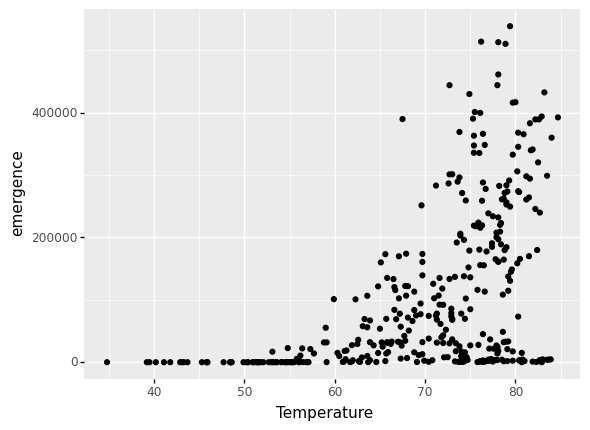

<ggplot: (2969560910954)>

In [5]:
pn.ggplot(df, pn.aes(x='Temperature', y='emergence')) + pn.geom_point() 

### Emergence by Day of year

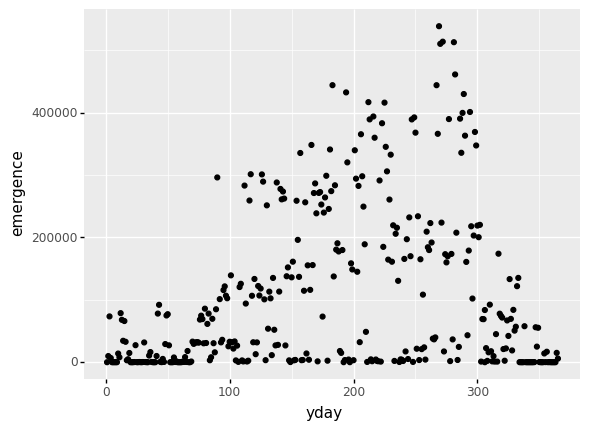

<ggplot: (2969561022805)>

In [6]:
pn.ggplot(df, pn.aes(x='yday', y='emergence')) + pn.geom_point() #+ pn.geom_smooth()

### Histogram of emergence dates

/apps/tensorflow/2.4.1.cuda10/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 11'. Pick better value with 'binwidth'.


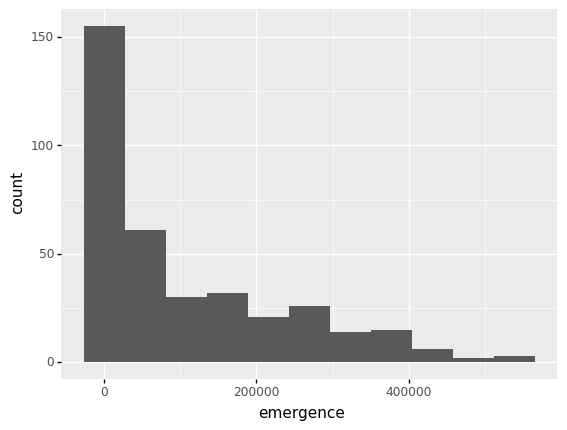

<ggplot: (2969561028247)>

In [8]:
pn.ggplot(df, pn.aes(x='emergence')) + pn.geom_histogram()

In [9]:
# Drop columns with missing data or that are text strings
df2 = df.drop(columns=['Unnamed: 0', 'Snow', 'Wind.Chill', 'Heat.Index', 'Wind.Gust', 'Snow.Depth', 'Wind.Direction', 'Conditions', 'Name', 'Date.time', 'day'])
df2

,Maximum.Temperature,Minimum.Temperature,Temperature,Precipitation,Wind.Speed,Visibility,Cloud.Cover,Relative.Humidity,yday,emergence
0,65.9,39.0,51.0,0.00,6.8,9.9,9.1,64.82,1,0
1,77.0,46.1,60.5,0.00,10.3,9.9,8.0,72.16,2,9856
2,83.0,63.0,72.9,0.00,13.8,9.6,43.3,79.95,3,73455
3,73.1,56.0,68.0,0.68,16.0,9.3,51.4,81.07,4,6720
4,61.1,39.0,48.5,0.00,12.7,9.9,0.0,57.43,5,0
...,...,...,...,...,...,...,...,...,...,...
360,63.0,25.1,42.9,0.00,10.2,9.9,0.0,69.97,361,0
361,71.9,37.2,53.0,0.00,6.9,9.9,5.0,74.20,362,0
362,71.9,39.9,54.5,0.00,12.6,9.9,7.1,75.82,363,0
363,75.8,46.3,60.3,0.00,12.6,8.5,37.8,83.65,364,15021


In [10]:
#make regress net
class BigRegressNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(9, 100),  # each neuron has 100 neurons that take 9 input variables each
            nn.Tanh(),
            nn.Linear(100,50), #each layer has 50 neurons that take 100 variables
            nn.Tanh(),
            nn.Linear(50,1)
        )
        
    def forward(self, X):
        y = self.layers(X)
        
        return y

In [13]:
# fit neural net
x = df2.drop(columns=['emergence']).to_numpy(np.float32)
y = df2[['emergence']].to_numpy(np.float32)

nn_model = NeuralNetRegressor(
    BigRegressNet,
    train_split=CVSplit(0.25),
    batch_size=len(df),
    criterion=nn.MSELoss,
    optimizer=torch.optim.SGD,
    max_epochs=400,
    lr=0.001,
    optimizer__momentum=0.9,
    optimizer__weight_decay=0.0005
)

pl = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', nn_model)
])

pl.fit(x, y)

  epoch        train_loss        valid_loss     dur
-------  ----------------  ----------------  ------
      1  27102468096.0000  31824003072.0000  0.0102
      2  27053447168.0000  31198545920.0000  0.0071
      3  26752677888.0000  30074898432.0000  0.0070
      4  26010804224.0000  28053753856.0000  0.0071
      5  24210632704.0000  26602229760.0000  0.0071
      6  23018889216.0000  25285629952.0000  0.0070
      7  22016563200.0000  23177281536.0000  0.0071
      8  20387174400.0000  21840142336.0000  0.0071
      9  19601334272.0000  20535267328.0000  0.0070
     10  18606598144.0000  19764275200.0000  0.0070
     11  18061971456.0000  18385201152.0000  0.0069
     12  17250222080.0000  18371837952.0000  0.0070
     13  17417666560.0000  17758173184.0000  0.0070
     14  16911128576.0000  17801893888.0000  0.0069
     15  16538574848.0000  16580487168.0000  0.0070
     16  16015596544.0000  16160897024.0000  0.0070
     17  15692825600.0000  15450080256.0000  0.0069
     18  156

Pipeline(steps=[('scaler', StandardScaler()),
                ('nn',
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=BigRegressNet(
    (layers): Sequential(
      (0): Linear(in_features=9, out_features=100, bias=True)
      (1): Tanh()
      (2): Linear(in_features=100, out_features=50, bias=True)
      (3): Tanh()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
  ),
))])

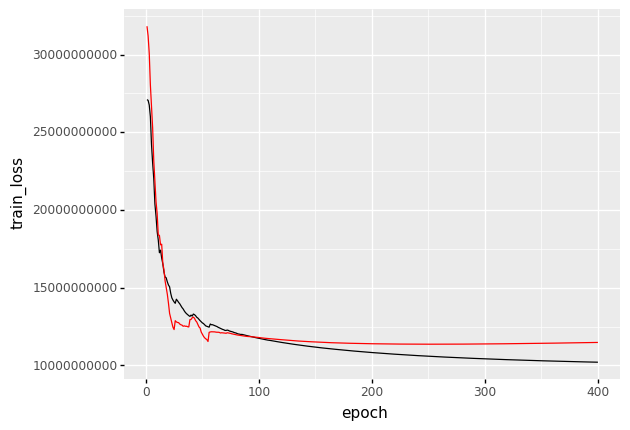

<ggplot: (2969561108128)>

In [14]:
#plot train vs test loss - train = black & test = red
tr_df = pd.DataFrame(nn_model.history)

pn.ggplot(tr_df) + pn.geom_line(pn.aes(x='epoch', y='train_loss')) + pn.geom_line(pn.aes(x='epoch', y='valid_loss'), color = "red")  #+ pn.ylim(0,10)

In [15]:
# predict neural net to original dataset
yyyy = pl.predict(x)
type(yyyy)
df_pred = pd.DataFrame(yyyy, columns = ['pred'])
df_all = pd.concat([df_pred, df2], axis=1)
df_all

,pred,Maximum.Temperature,Minimum.Temperature,Temperature,Precipitation,Wind.Speed,Visibility,Cloud.Cover,Relative.Humidity,yday,emergence
0,46209.816406,65.9,39.0,51.0,0.00,6.8,9.9,9.1,64.82,1,0
1,-60811.554688,77.0,46.1,60.5,0.00,10.3,9.9,8.0,72.16,2,9856
2,87365.664062,83.0,63.0,72.9,0.00,13.8,9.6,43.3,79.95,3,73455
3,-40832.187500,73.1,56.0,68.0,0.68,16.0,9.3,51.4,81.07,4,6720
4,-29189.937500,61.1,39.0,48.5,0.00,12.7,9.9,0.0,57.43,5,0
...,...,...,...,...,...,...,...,...,...,...,...
360,33819.296875,63.0,25.1,42.9,0.00,10.2,9.9,0.0,69.97,361,0
361,4150.605469,71.9,37.2,53.0,0.00,6.9,9.9,5.0,74.20,362,0
362,4150.605469,71.9,39.9,54.5,0.00,12.6,9.9,7.1,75.82,363,0
363,-29865.070312,75.8,46.3,60.3,0.00,12.6,8.5,37.8,83.65,364,15021


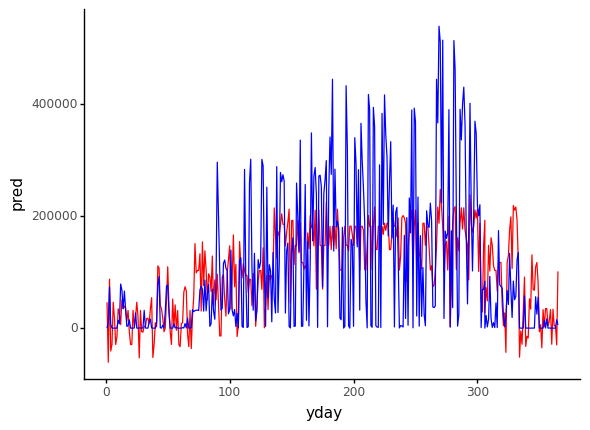

<ggplot: (2969561935972)>

In [16]:
# plot predicted emergence (red) vs simulated emergence (blue)
pn.ggplot(df_all) + pn.aes(x='yday') + pn.geom_path(pn.aes(y='pred'), color = "red") + pn.geom_path(pn.aes(y='emergence'), color = "blue") + pn.theme_classic()

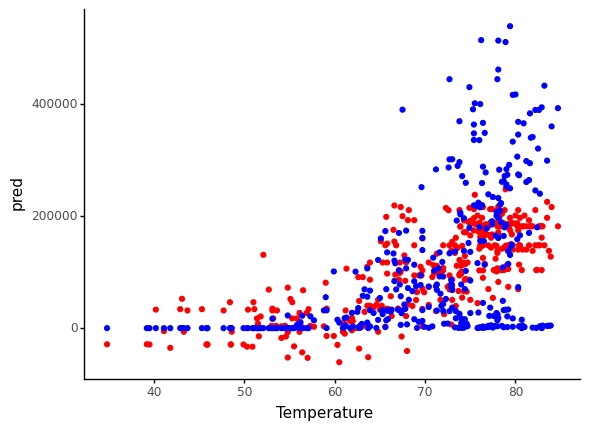

<ggplot: (2969561960174)>

In [17]:
pn.ggplot(df_all) + pn.aes(x='Temperature') + pn.geom_point(pn.aes(y='pred'), color = "red") + pn.geom_point(pn.aes(y='emergence'), color = "blue")+ pn.theme_classic()

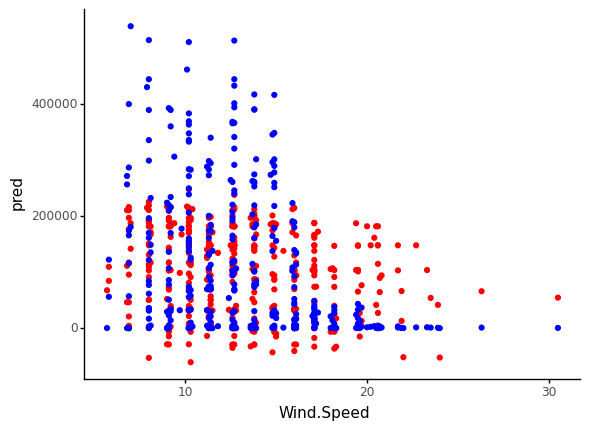

<ggplot: (2969562384074)>

In [18]:
pn.ggplot(df_all) + pn.aes(x='Wind.Speed') + pn.geom_point(pn.aes(y='pred'), color = "red") + pn.geom_point(pn.aes(y='emergence'), color = "blue")+ pn.theme_classic()

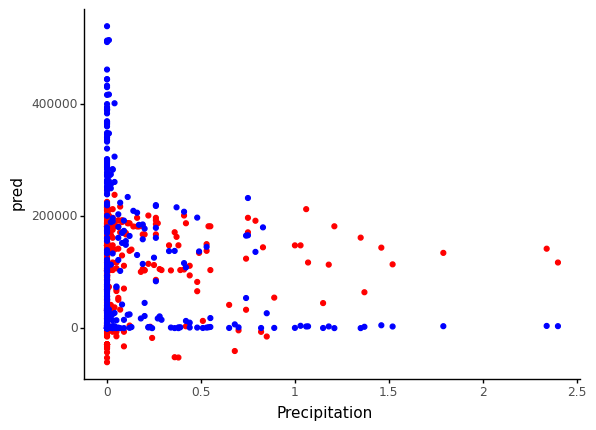

<ggplot: (2969562371774)>

In [20]:
pn.ggplot(df_all) + pn.aes(x='Precipitation') + pn.geom_point(pn.aes(y='pred'), color = "red") + pn.geom_point(pn.aes(y='emergence'), color = "blue")+ pn.theme_classic()

In [21]:
# get forecasted weather data. Put into np array and predict using neural net for a "Bat Cast!"
mon = [76,63,70,0.13,2,9.9,31,67,109]
mon = np.asarray(mon, dtype = 'float32')

tue = [72,58,65,0.2,4,9.9,77,79,110]
tue = np.asarray(tue, dtype = 'float32')

wed = [81,51,76,0,6,9.9,3,44,111]
wed = np.asarray(wed, dtype = 'float32')

In [24]:
#print bat cast
print(pl.predict(mon.reshape(1,-1)))
print(pl.predict(tue.reshape(1,-1)))
print(pl.predict(wed.reshape(1,-1)))

[[177286.94]]
[[55031.906]]
[[89480.72]]
